## NLP
### Reconhecimento de Entidades Nomeadas (NER)
<b>Objetivo: </b> Entender como modelar e treinar modelos para reconhecimento de entidade nomeada.
<br><b>Autora:</b> Renata Gotler

Modelos de Reconhecimento de Entidades Nomeadas visam extrair do texto informações categorizadas como:
- Pessoa (PER): Nome de pessoas.
- Organização (ORG): Empresas e instituições.
- Localização (LOC): Cidades, países, regiões geográficas.
- Miscellaneous (MISC): Outros, o que não for das categorias acima mas ainda assim for importante, como evento ou produtos.
<br>A ideia do NER é classificar cada token dentro do texto entre uma dessas opções.
<br><br>O forma de classificação mais comum é a Inside-Outside-Beginning (IOB):
- B- (Beginning): Marca o início de uma entidade.
- I- (Inside): Marca o token de dentro da entidade, contínuo ao anterior.
- O (Outside): Marca um token que não faz parte de nenhuma entidade nomeada.
<br>Nesse formato, o modelo tem todas as informações para distinguir de forma clara quando uma entidade nomeada começa e quando termina.

#### Usando modelos pré-treinados

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


##### NLTK
Modelo pré-treinado no idioma inglês.
<br>Podemos ver que ele se perde bastante no exemplo usado, classificando o "Bem" como GPE (localização), Reconhecimento como organização, mas também acertar em outras, como FIAP como Organização e Renata Gotler como pessoa.

<br>Ainda conseguimos usar mesmo que com um erro maior alguns modelos pré-treinados em outros idiomas, desde que eles possuam padrões em comum. Por exemplo, as línguas da família Indo-Européia como espanhol, inglês, português, russo, alemão, francês e outros, possuem padrões que podem fazer com que um modelo pré-treinado em uma, possa ser usado em outra. Já se fossemos testar em textos japoneses, esses modelos teriam uma performance bem mais baixa, visto que são idiomas bem diferentes.

In [ ]:
texto = "Bem vindos a aula de Reconhecimento de Entidades Nomeadas da FIAP ministrada pela professora Renata Gotler"
tokens = word_tokenize(texto)
taggeado = pos_tag(tokens)
entidades = ne_chunk(taggeado)
print(entidades)

(S
  (GPE Bem/NNP)
  vindos/VBZ
  a/DT
  aula/NN
  de/FW
  (ORGANIZATION Reconhecimento/NNP)
  de/FW
  (PERSON Entidades/NNP Nomeadas/NNP)
  da/NN
  (ORGANIZATION FIAP/NNP)
  ministrada/NN
  pela/NN
  professora/NN
  (PERSON Renata/NNP Gotler/NNP))


Se testaremos o mesmo texto em inglês, vemos que o resultado melhora bastante, mesmo que ainda fazendo um pequeno erro.

In [ ]:
text = "Welcome to the Named Entity Recognition class from FIAP lectured by teacher Renata Gotler"
tokens = word_tokenize(text)
taggeado = pos_tag(tokens)
entidades = ne_chunk(taggeado)
print(entidades)

(S
  Welcome/VB
  to/TO
  the/DT
  (ORGANIZATION Named/NNP Entity/NNP)
  Recognition/NNP
  class/NN
  from/IN
  (ORGANIZATION FIAP/NNP)
  lectured/VBN
  by/IN
  teacher/NN
  (PERSON Renata/NNP Gotler/NNP))


##### Spacy
A biblioteca spacy possui um modelo NER pré-treinado no idioma português, vamos testá-lo? Olha que legal, tudo bem certinho, identificou a organização FIAP e a pessoa Renata Gotler.

In [ ]:
import spacy
nlp = spacy.load('pt_core_news_sm')
doc = nlp(texto)
for ent in doc.ents:
    print(ent.text, ent.label_)

FIAP ORG
Renata Gotler PER


##### Fine-tuned BERT
O modelo abaixo foi pré-treinado na tarefa de reconhecimento de entidades nomeadas usando como corpo o BERTimbau, que é pré-treinado na língua portuguesa. Dessa forma, uma cabeça de classificação de entidades foi adicionada usando artigos da Globo News. Mais informações sobre o modelo estão disponíveis na [documentação](https://huggingface.co/monilouise/ner_news_portuguese).

<br> Abaixo podemos ver que FIAP não foi identificada como uma entidade nomeada, mas Renata Gotler foi classificada corretamente como pessoa.

In [ ]:
from transformers import BertForTokenClassification, DistilBertTokenizerFast, pipeline
model = BertForTokenClassification.from_pretrained(
    'monilouise/ner_pt_br', cache_dir="../models/"
)
tokenizer = DistilBertTokenizerFast.from_pretrained(
    'neuralmind/bert-base-portuguese-cased',
    model_max_length=512,
    do_lower_case=False,
    cache_dir="../models/"
)
ner = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)
entidades = ner(texto)
for ent in entidades:
    print(f"{ent['word']}: {ent['entity_group']} ({ent['score']:.2f})")

c:\Users\RenataGotler\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\RenataGotler\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RenataGotler\Repositórios\Pos_Tech_MLET\nlp\models\models--monilouise--ner_pt_br. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Devel

Rena: PESSOA (0.96)
##ta: PESSOA (0.59)
Got: PESSOA (0.97)


c:\Users\RenataGotler\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


Agora que já usamos modelos prontos, vamos ver como treinar o nosso próprio?

#### Treinando um modelo multi linguagem

Prontos para treinar um modelo multi linguagem para Reconhecimento de Entidade Nomeada (NER)? Para isso, vamos usar um pedaço do dataset “XTREME” (Cross-lingual TRansfer Evaluation of Multilingual Encoders), chamado de WikiANN ou PAN-X.

In [17]:
from collections import defaultdict, Counter

import torch
import pandas as pd
import numpy as np
from datasets import DatasetDict, load_dataset, get_dataset_config_names
from transformers import (
    XLMRobertaForTokenClassification,
    AutoTokenizer,
    AutoConfig,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from seqeval.metrics import f1_score

Esse dataset possui 183 subsets (idiomas), com um padrão de PAN-x. e a sigla do idioma.

In [18]:
xtreme_subsets = get_dataset_config_names("xtreme") 
print(f"XTREME possui {len(xtreme_subsets)} configurações.") 
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
print(panx_subsets[:3])

XTREME possui 183 configurações.
['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']


Vamos pegar os seguintes idiomas: inglês, português e francês. Além disso, vamos fazer uma redução do dataset por proporções para termos uma visão mais realista. Datasets desbalanceados são muito comuns em problemas na vida real, pense na proporção de pessoas que falam um determinado idioma, é muito mais fácil conseguir dados em inglês do que nos demais idiomas, certo?

In [19]:
langs = ['pt', 'en', 'fr']
prop = [0.13, 0.72, 0.15]
panx_ch = defaultdict(DatasetDict)
for lang, prop in zip(langs, prop):
	ds = load_dataset('xtreme', name=f'PAN-X.{lang}')
	for split in ds:
		panx_ch[lang][split] = ds[split].shuffle(seed=0).select(
            range(int(prop * ds[split].num_rows))
        )
pd.DataFrame(
	{
		lang: [panx_ch[lang]['train'].num_rows]
		for lang in langs
	}, index=['Número de observações de treino']
)


,pt,en,fr
Número de observações de treino,2600,14400,3000


Primeiramente vamos treinar nosso modelo na língua inglesa e testarmos ele na língua inglesa, portuguesa e francesa.
<br>Dessa forma, vamos inspecionar um exemplo no dataset inglês.

In [20]:
exemplo = panx_ch['en']['train'][0]
for key, value in exemplo.items():
    print(f'{key}: {value}')

tokens: ["'", "''", 'Toronto', 'Lynx', "''", "'"]
ner_tags: [0, 0, 3, 4, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en', 'en']


Podemos ver que a coluna ner_tags corresponde a um código mapeado, então vamos transformá-lo em uma nova coluna mais familiar, com as tags LOC, PER e ORG. Podemos fazer isso através do atributo features.

In [21]:
for key, value in panx_ch['en']['train'].features.items():
	print(f'{key}: {value}')

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


Agora vamos criar uma função que cria a coluna ner_tags_str usando a feature ner_tags que possui uma classe ClassLabel que mapeia o id com a tag.

In [22]:
tags = panx_ch['en']['train'].features['ner_tags'].feature
def create_tag_names_column(batch):
	return {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}
panx_en = panx_ch['en'].map(create_tag_names_column)
exemplo = panx_en['train'][0]
pd.DataFrame([exemplo['tokens'], exemplo['ner_tags_str']], ['tokens', 'tags'])


,0,1,2,3,4,5
tokens,','',Toronto,Lynx,'','
tags,O,O,B-ORG,I-ORG,O,O


Acima já vemos alguns desafios que enfrentamos lidando com idiomas: Toronto é uma cidade, que seria classificado como local, mas Toronto Lynx é um time de futebol, então é classificado como organização. Outro desafio importante é a criação das tags, podemos ver que é bem trabalhoso e complexo de taggear todas as sentenças de um dataset inteiro para treinarmos o modelo.

Agora faremos uma Análise Exploratória, para entender a quantidade de tags que temos em cada dataset e ver se estão homogênias.

In [23]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_en.items():
	for row in dataset['ner_tags_str']:
		for tag in row:
			if tag.startswith('B'):
				tag_type = tag.split('-')[1]
				split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient='index')


,ORG,PER,LOC
train,6715,6542,6767
validation,3364,3276,3458
test,3385,3339,3357


Agora que vimos o dataset, vamos para o modelo...
<br>Nesse exemplo usaremos o modelo [XLM-RoBERTa](https://huggingface.co/docs/transformers/model_doc/xlm-roberta). O modelo RoBERTa modifica o pré-treinamento do BERT, melhorando o modelo ao treinar em mais dados por mais tempo, além de não realizar a tarefa de Next Sentence Prediction. O XLM-RoBERTa, por sua vez, estende o RoBERTa para um pré-treinamento multi-língua. Outra diferença para o BERT é a tokenização: Enquanto o BERT tokeniza usando WordPiece, o XLM-RoBERTa utiliza o SentencePiece. Essa mudança de tokenização é especialmente importante para lidar com línguas em que a separação por espaço não faz sentido, como na língua japonesa, sendo mais agnóstica.

In [24]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="../models/")
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
config = AutoConfig.from_pretrained(
	model_name,
	num_labels=tags.num_classes,
	id2label=index2tag,
	label2id=tag2index,
    cache_dir="../models/"
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XLMRobertaForTokenClassification.from_pretrained(
    model_name, config=config, cache_dir="../models/"
).to(device)


c:\Users\RenataGotler\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Antes de fazer o fine-tuning do modelo, primeiro precisamos tokenizar nosso dataset e alinhar e limpar nossos labels. 
<br>Não queremos que tokens de carácter especial, como o `<s>` e o `<\s>` que indicam início e fim de sentença sejam classificados, e também queremos ignorar a classificação das subpalavras, somente a primeira deve ser classificada, as demais serão tratadas posteriormente quando juntarmos os tokens em palavras. Para isso, vamos usar os word_ids. Vamos ver um exemplo abaixo.


In [25]:
tokenized_input = tokenizer(exemplo['tokens'], is_split_into_words=True) 
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"]) 
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word Ids"]) 

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁',▁'',▁Toronto,▁Lyn,x,▁'',▁',</s>
Word Ids,None,0,1,2,3,3,4,5,None


Podemos ver acima que os caracteres especiais estão com Ids None. Além disso, as subpalavras possuem o mesmo id da anterior: A palavra Lynx foi dividida em ▁Lyn e x por exemplo, ambas com o id 3. Com isso, podemos tratar os labels para quando forem None ou iguais ao anterior, alocamos o label id -100. Porque -100? Porque a classe torch.nn.CrossEntropyLoss possui um atributo chamado ignore_index com valor -100. Dessa forma, os tokens associados com label -100 serão ignorados durante o treinamento.

In [26]:
def tokenize_and_align_labels(examples):
	tokenized_inputs = tokenizer(
		examples['tokens'], truncation=True, is_split_into_words=True
	)
	labels = []
	for idx, label in enumerate(examples['ner_tags']):
		word_ids = tokenized_inputs.word_ids(batch_index=idx)
		previous_word_idx = None
		labels_ids = []
		for word_idx in word_ids:
			if word_idx is None or word_idx == previous_word_idx:
				labels_ids.append(-100)
			else:
				labels_ids.append(label[word_idx])
			previous_word_idx = word_idx
		labels.append(labels_ids)
	tokenized_inputs['labels'] = labels
	return tokenized_inputs
def encode_panx_dataset(corpus):
	return corpus.map(
		tokenize_and_align_labels,
		batched=True,
		remove_columns=['langs', 'ner_tags', 'tokens']
	)
panx_en_encoded = encode_panx_dataset(panx_ch['en'])


Map: 100%|██████████| 7200/7200 [00:00<00:00, 22705.34 examples/s]


A avaliação de um modelo NER é similar ao de modelos de classificação, usando métricas como acuracidade, precision, recall, f1-score. A diferença é que todas as palavras de uma entidade precisam ser previstas corretamente para uma previsão contar como correta. Para isso, usaremos a biblioteca seqeval, que faz exatamente isso. Veja um exemplo abaixo.

In [27]:
from seqeval.metrics import classification_report
y_true = [
    ['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'],
    ['B-PER', 'I-PER', 'O']
]
y_pred = [
    ['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'],
    ['B-PER', 'I-PER', 'O']
]
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



Para usar essa biblioteca, precisaremos formatar as previsões e os labels para formato de lista de listas, conforme visto acima, onde cada lista corresponde a um registro do dataset.

In [28]:
def align_predictions(predictions, label_ids):
	preds = np.argmax(predictions, axis=2)
	batch_size, seq_len = preds.shape
	labels_list, preds_list = [], []
	for batch_idx in range(batch_size):
		example_label, example_preds = [], []
		for seq_idx in range(seq_len):
			if label_ids[batch_idx, seq_idx] != -100:
				example_label.append(
                    index2tag[label_ids[batch_idx][seq_idx]]
                )
				example_preds.append(
                    index2tag[preds[batch_idx][seq_idx]]
                )
		labels_list.append(example_label)
		preds_list.append(example_preds)
	return preds_list, labels_list


Agora temos tudo que precisamos para fazer o fine-tuning do XLM-RoBERTa. Primeiramente, faremos somente no subset do idioma inglês e testaremos o modelo nos demais idiomas, português e francês. Essa parte já fica bem parecida com a da aula passada de análise de sentimento.

In [29]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_en_encoded['train']) // batch_size
finetuned_model_name = f'../models/{model_name}-finetuned-panx-en'
training_args = TrainingArguments(
    output_dir=finetuned_model_name,
    log_level='error',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
)

def compute_metrics(eval_pred):
	y_pred, y_true = align_predictions(
        eval_pred.predictions, eval_pred.label_ids
    )
	return {'f1': f1_score(y_true, y_pred)}

c:\Users\RenataGotler\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Por fim, precisamos aplicar o método pad para deixar todas as sequências do mesmo tamanho em uma batch (lote). Para isso, usaremos o data collator. Precisamos aplicá-lo tanto no texto como nos labels, porque agora temos labels de tamanhos diferentes, são labels sequenciais, ao contrário do que tínhamos na aula passada na análise de sentimento, onde tínhamos somente a previsão de uma classe. O pad seguirá a mesma lógica implementada, transformando os tokens pad para ids de -100 para serem ignorados durante o treinamento.

In [31]:
data_collator = DataCollatorForTokenClassification(tokenizer)
trainer = Trainer(
    model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_en_encoded['train'],
    eval_dataset=panx_en_encoded['validation'],
    tokenizer=tokenizer
)
trainer.train()

 14%|█▍        | 252/1800 [57:22<5:52:29, 13.66s/it]
                                                     
 33%|███▎      | 600/1800 [58:45<1:46:01,  5.30s/it]

{'loss': 0.3146, 'grad_norm': 7.7775797843933105, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}














































































































































































































































































































                                                    
                                                   

 33%|███▎      | 600/1800 [1:03:55<1:46:01,  5.30s/it]



{'eval_loss': 0.2852923572063446, 'eval_f1': 0.7795589235402701, 'eval_runtime': 310.3612, 'eval_samples_per_second': 23.199, 'eval_steps_per_second': 0.967, 'epoch': 1.0}


                                                       
 67%|██████▋   | 1200/1800 [1:51:41<49:57,  5.00s/it] 

{'loss': 0.2291, 'grad_norm': 5.066575050354004, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}














































































































































































































































































































                                                     
                                                   

 67%|██████▋   | 1200/1800 [1:56:23<49:57,  5.00s/it]



{'eval_loss': 0.2691309452056885, 'eval_f1': 0.797154072620216, 'eval_runtime': 282.8361, 'eval_samples_per_second': 25.456, 'eval_steps_per_second': 1.061, 'epoch': 2.0}


                                                        
100%|██████████| 1800/1800 [2:45:21<00:00,  3.93s/it] 

{'loss': 0.1606, 'grad_norm': 1.9625195264816284, 'learning_rate': 0.0, 'epoch': 3.0}














































































































































































































































































































                                                     
                                                   

100%|██████████| 1800/1800 [2:50:08<00:00,  3.93s/it]

                                                     
100%|██████████| 1800/1800 [2:50:08<00:00,  5.67s/it] 

{'eval_loss': 0.27013665437698364, 'eval_f1': 0.8118384947079577, 'eval_runtime': 286.7881, 'eval_samples_per_second': 25.106, 'eval_steps_per_second': 1.046, 'epoch': 3.0}
{'train_runtime': 10208.4417, 'train_samples_per_second': 4.232, 'train_steps_per_second': 0.176, 'train_loss': 0.23476712544759115, 'epoch': 3.0}


TrainOutput(global_step=1800, training_loss=0.23476712544759115, metrics={'train_runtime': 10208.4417, 'train_samples_per_second': 4.232, 'train_steps_per_second': 0.176, 'total_flos': 840013140205008.0, 'train_loss': 0.23476712544759115, 'epoch': 3.0})

O treinamento pode demorar bastante, tenha paciência. Acima podemos ver que os resultados foram muito bons! Com F1 de cerca de 81%! Após, já teremos nosso modelo treinado, agora é só formatar o resultado final.

In [32]:
def tag_text(text, tags, model, tokenizer):
	tokens = tokenizer(text).tokens()
	input_ids = tokenizer(text, return_tensors='pt').input_ids.to(device)
	outputs = model(input_ids)[0]
	predictions = torch.argmax(outputs, dim=2)
	preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
	return pd.Dataframe([tokens, preds], index=['Tokens', 'Tags'])

def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics['test_f1']

def evaluate_lang_performance(lang, trainer):
	panx_ds = encode_panx_dataset(panx_ch[lang])
	return get_f1_score(trainer, panx_ds['test'])

O nosso modelo até então foi treinado somente em texto do idioma inglês, será que ele já performa bem nos idiomas português e francês?

In [33]:
f1_scores = defaultdict(dict)
for lang in langs:
	f1_scores['en'][lang] = evaluate_lang_performance(lang, trainer)
f1_scores

100%|██████████| 63/63 [00:47<00:00,  1.33it/s]


defaultdict(dict,
            {'en': {'pt': 0.755090168702734,
              'en': 0.819514586908556,
              'fr': 0.7384541756401053}})

Incrível! Mesmo o treinamento sendo no idioma inglês, já conseguimos usar esse modelo nos outros idiomas com uma boa performance, com F1 de cerca de 75%.
<br>Mas ainda podemos melhorar, podemos treinar um modelo em todos os idiomas de uma vez.


In [34]:
from datasets import concatenate_datasets
def concatenate_splits(corpus):
	multi_corpus = DatasetDict()
	for split in corpus[0].keys():
		multi_corpus[split] = concatenate_datasets(
			[data[split] for data in corpus]
		).shuffle(seed=42)
	return multi_corpus

panx_all_encoded = [panx_en_encoded]
for lang in ['pt', 'fr']:
	panx_encoded = encode_panx_dataset(panx_ch[lang])
	panx_all_encoded.append(panx_encoded)
corpus = concatenate_splits(panx_all_encoded)
training_args.output_dir = f'../models/{model_name}-finetuned-panx-all'
training_args.logging_steps = len(corpus['train']) // batch_size
trainer = Trainer(model,args=training_args, data_collator=data_collator, compute_metrics=compute_metrics, train_dataset=corpus['train'], eval_dataset=corpus['validation'], tokenizer=tokenizer)
trainer.train()

 33%|███▎      | 833/2502 [1:06:41<2:04:56,  4.49s/it]

{'loss': 0.2325, 'grad_norm': 4.244439601898193, 'learning_rate': 3.3353317346123105e-05, 'epoch': 1.0}


 33%|███▎      | 834/2502 [1:06:43<1:49:40,  3.95s/it]


































































































































































































































































































































































































































                                           
                                                      
 33%|███▎      | 834/2502 [1:13:41<1:49:40,  3.95s/it]


{'eval_loss': 0.26804468035697937, 'eval_f1': 0.8145848375451263, 'eval_runtime': 417.4688, 'eval_samples_per_second': 23.954, 'eval_steps_per_second': 0.999, 'epoch': 1.0}


 67%|██████▋   | 1666/2502 [2:22:01<1:02:52,  4.51s/it]

{'loss': 0.1618, 'grad_norm': 8.026433944702148, 'learning_rate': 1.6706634692246204e-05, 'epoch': 2.0}


 67%|██████▋   | 1668/2502 [2:22:09<58:12,  4.19s/it]  


































































































































































































































































































































































































































                                           
                                                      
 67%|██████▋   | 1668/2502 [2:29:37<58:12,  4.19s/it]


{'eval_loss': 0.28700748085975647, 'eval_f1': 0.8219504275354476, 'eval_runtime': 447.2561, 'eval_samples_per_second': 22.359, 'eval_steps_per_second': 0.932, 'epoch': 2.0}


100%|█████████▉| 2499/2502 [3:37:56<00:13,  4.57s/it] 

{'loss': 0.1, 'grad_norm': 17.973731994628906, 'learning_rate': 5.995203836930455e-08, 'epoch': 3.0}


100%|██████████| 2502/2502 [3:38:10<00:00,  4.34s/it]


































































































































































































































































































































































































































                                           
                                                      
100%|██████████| 2502/2502 [3:44:55<00:00,  4.34s/it]

100%|██████████| 2502/2502 [3:44:55<00:00,  5.39s/it] 

{'eval_loss': 0.3139559030532837, 'eval_f1': 0.8286924720280987, 'eval_runtime': 404.9415, 'eval_samples_per_second': 24.695, 'eval_steps_per_second': 1.03, 'epoch': 3.0}
{'train_runtime': 13495.3183, 'train_samples_per_second': 4.446, 'train_steps_per_second': 0.185, 'train_loss': 0.16469408920724138, 'epoch': 3.0}


TrainOutput(global_step=2502, training_loss=0.16469408920724138, metrics={'train_runtime': 13495.3183, 'train_samples_per_second': 4.446, 'train_steps_per_second': 0.185, 'total_flos': 1143126996806784.0, 'train_loss': 0.16469408920724138, 'epoch': 3.0})

Que resultado! 83% de F1 score no total! Agora vamos testar o modelo multi linguagem nos nossos datasets e ver como ficou.

In [35]:
for idx, lang in enumerate(langs):
	f1_scores['all'][lang] = get_f1_score(
		trainer, panx_all_encoded[idx]['test']
	)
scores_data = {
	'en': f1_scores['en'],
	'all': f1_scores['all'],
}
f1_scores_df = pd.DataFrame(scores_data).T.round(4).rename_axis(
	index='Fine-tuned on', columns= 'Evaluated on'
)
f1_scores_df

100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Evaluated on,pt,en,fr
Fine-tuned on,,,
en,0.7551,0.8195,0.7385
all,0.8243,0.8746,0.8615


Veja que usar outros idiomas no treinamento aumentou o resultado testando somente no dataset em inglês também, indo de 82% para 87% em F1! Isso porque ele aprendeu outros padrões com os outros idiomas que puderam ser aproveitados. No entanto, isso é verdade para aqueles idiomas que são similares, conforme comentamos anteriormente, todos os idiomas testados pertencem à família Indo-Européia, que compartilham padrões entre si. Esses padrões fazem com que o modelo performe de forma quase equivalente nesses idiomas, podemos ver que o F1 em todos os três idiomas ficou bem parecido, em torno de 85%, o que é muito bom para um modelo de Reconhecimento de Entidade Nomeada.

### Análise de Erro

Por fim, é sempre importante fazer uma análise de erro para entender as fraquezas e forças do seu modelo, entendendo potenciais melhorias ou até vendo possíveis viéses.
<br>Podemos fazer isso extraindo a loss e a classe prevista para cada token de cada registro, comparando com a classe verdadeira do token do registro. Na análise de erro, podemos olhar para os registros com as maiores loss.

In [36]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    loss = cross_entropy(output.logits.view(-1,7), labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss": loss, "predicted_label": predicted_label}

In [37]:
valid_set = panx_en_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map: 100%|██████████| 7200/7200 [05:28<00:00, 21.94 examples/s]


Precisamos extrair is tokens, até então só temos os ids para melhorar nossa leitura. Além disso, vamos retirar o padding adicionado anteriormente limitando pelo tamanho do dado de entrada (input_ids).

In [38]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
for label in ["predicted_label", "labels"]:
    df[label] = df[label].apply(lambda x: [index2tag[i] for i in x])
for col in ["loss", "predicted_label"]:
    df[col] = df.apply(lambda x: x[col][:len(x["input_ids"])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 111767, 87, 1529, 5861, 1650, 194397, 70, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, B-ORG, I-ORG, IGN, I-ORG, I-ORG, I-OR...","[0.0, 0.00023600654, 0.0011836435, 0.001912075...","[I-ORG, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, ...","[<s>, ▁``, ▁I, ▁He, ard, ▁It, ▁Through, ▁the, ..."


Agora vamos olhar para os tokens de forma individual, explodindo as listas, criando uma linha por token. Também vamos retirar os labels IGN que possuem loss zero de qualquer forma.

In [39]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens[df_tokens["labels"] != "IGN"]
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,111767,1,O,0.0,O,▁``
0,87,1,B-ORG,0.0,B-ORG,▁I
0,1529,1,I-ORG,0.0,I-ORG,▁He
0,1650,1,I-ORG,0.0,I-ORG,▁It
0,194397,1,I-ORG,0.0,I-ORG,▁Through


Agora podemos agrupar os dados por token e agregar a loss, extraindo contagem, média e soma. Podemos ver que o token que acumulou a maior loss no dataset de validação é o _, seguido por _of e assim por diante...
<br>Isso nos dá alguns insights importantes:
- o token `_` representa espaço, ele ter obtido a maior loss acumulada não é surpresa, visto que ele é o token mais frequente também. Além disso, a média da loss desse token indica que o modelo não tem problemas em classificar ele.
- os tokens `_of`, `_the`, `_and` e outros na lista aparencem com bastante frequência. Esses tokens aparecem bastante juntos com entidade nomeadas e as vezes fazem parte delas, o que explica o porque o modelo fica confuso com eles.
- Parênteses no início das palavras apareceram com uma frequencia relativamente alta e uma média de loss bem alta também, precisando de investigação.

In [40]:
df_tokens.groupby("input_tokens")[["loss"]].agg(
    ["count", "mean", "sum"]
).droplevel(level=0, axis=1).sort_values(
    by="sum", ascending=False
).reset_index().round(2).head(10).T

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁of,▁),▁(,▁the,▁and,▁'',▁The,▁',▁in
count,5550,1356,1927,1931,1142,726,2775,336,1317,910
mean,0.17,0.49,0.25,0.25,0.31,0.33,0.06,0.48,0.11,0.16
sum,927.96,669.83,490.93,488.31,353.17,241.58,165.59,162.77,150.59,149.86


Analisando pelos labels, podemos ver que a maior loss acumulada é da classe I-ORG, sendo onde nosso modelo tem maior dificuldade.

In [46]:
df_tokens.groupby("labels")[["loss"]].agg(
    ["count", "mean", "sum"]
).droplevel(level=0, axis=1).sort_values(
    by="sum", ascending=False
).reset_index().round(2).head(10).T

,0,1,2,3,4,5,6
labels,I-ORG,I-LOC,I-PER,B-ORG,O,B-LOC,B-PER
count,8384,4564,5337,3364,29398,3458,3276
mean,0.52,0.71,0.55,0.71,0.07,0.47,0.42
sum,4391.25,3261.51,2949.29,2384.79,2201.95,1617.1,1361.11


Podemos quebrar ainda mais e ver a matriz de confusão. Abaixo vemos que:
- Nosso modelo se confunde entre o B-ORG (início de organização) e o I-ORG (token subsequente).
- O modelo também se confunde bastante entre a classe B-PER com O e I-PER.
- Em geral nosso modelo é um bom modelo, podemos ver isso claremente pela diagonal da matriz de confusão.

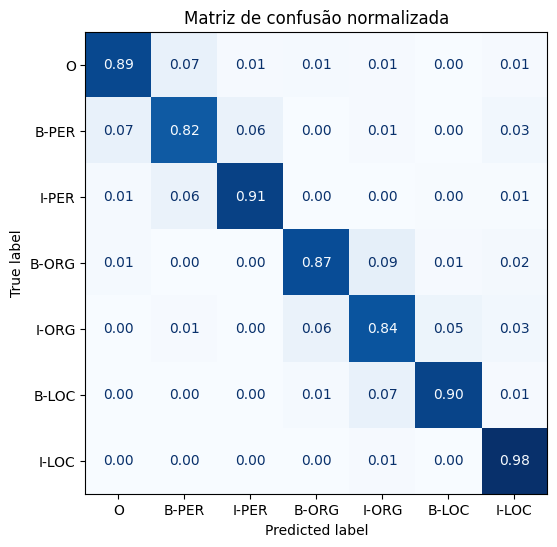

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    _, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Matriz de confusão normalizada")
    plt.show()
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

Agora analisamos a nível de token, vamos avaliar alguns exemplos (sequências). Para isso, voltamos para nosso dataset não explodido e somamos as losses de cada token na sequência.

In [43]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, _ in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T
        yield df_tmp

Abaixo podemos ver os 2 registros com maior loss total. Algumas coisas interessantes nesses registros:
- Temos um token `_alt` classificado `B-ORG`, mas é uma classificação errada, assim como `Justin Timberlake` não é não é uma organização, nosso modelo na verdade está correto. Isso pode acontecer, visto que os dados do PAN-X foram gerados em um process automático. Essas classificações são consideradas "padrão prata", contrastando com as classificações "padrão ouro" feitas por humanos. Mesmo com classificações "padrão ouro", ainde podemos ter erros nos labels dos nossos dados. 

In [44]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
tokens,▁alt,=,High,▁school,▁building,▁with,▁a,▁two,-,story,...,ground,▁and,▁a,▁round,▁auditori,um,▁in,▁the,▁background,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,...,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,O,O,B-ORG,I-ORG,I-LOC,O,O,O,O,I-LOC,...,O,O,O,O,O,O,O,O,O,O
losses,4.27,0.00,0.00,0.60,0.82,8.49,8.72,6.42,0.00,0.00,...,0.00,9.20,9.22,6.12,3.95,0.00,8.42,8.47,8.37,0.00


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
tokens,▁',▁'',▁Justin,▁Tim,ber,la,ke,▁-,▁Mirror,s,...,▁40,▁1,▁,",",▁February,▁11,▁),▁'',▁',</s>
labels,O,O,B-ORG,I-ORG,IGN,IGN,IGN,I-ORG,I-ORG,IGN,...,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,O,O,IGN
preds,O,O,B-PER,I-PER,I-PER,I-PER,I-PER,O,B-ORG,I-ORG,...,I-LOC,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,6.02,5.37,0.00,0.00,0.00,10.44,7.66,0.00,...,2.97,8.72,10.24,0.00,9.25,9.64,10.04,0.00,0.00,0.00


Conforme vimos anteriormente, parênteses tinham uma loss relativamente alta, vamos ver alguns exemplos?
<br> Em geral os parênteses e seus conteúdos não fazem parte das entidades nomeadas, mas em alguns casos parece que isso está acontecendo.

In [45]:
df_tmp = df.loc[
    df["input_tokens"].apply(lambda x: u"\u2581(" in x)
].sort_values(by="total_loss", ascending=False).head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
tokens,▁',▁'',▁Justin,▁Tim,ber,la,ke,▁-,▁Mirror,s,...,▁40,▁1,▁,",",▁February,▁11,▁),▁'',▁',</s>
labels,O,O,B-ORG,I-ORG,IGN,IGN,IGN,I-ORG,I-ORG,IGN,...,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,O,O,IGN
preds,O,O,B-PER,I-PER,I-PER,I-PER,I-PER,O,B-ORG,I-ORG,...,I-LOC,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,6.02,5.37,0.00,0.00,0.00,10.44,7.66,0.00,...,2.97,8.72,10.24,0.00,9.25,9.64,10.04,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
tokens,▁Iron,▁Man,▁:,▁Ar,mo,red,▁Adventure,s,▁'',▁–,...,▁Van,ko,▁(,▁Cri,m,son,▁Dyna,mo,▁),</s>
labels,B-PER,I-PER,I-PER,I-PER,IGN,IGN,I-PER,IGN,O,O,...,I-PER,IGN,I-PER,I-PER,IGN,IGN,I-PER,IGN,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,O,...,I-PER,I-PER,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,I-ORG
losses,5.65,6.56,6.94,6.96,0.00,0.00,5.99,0.00,0.00,0.00,...,0.01,0.00,7.13,9.24,0.00,0.00,4.71,0.00,8.73,0.00


Com algumas análises simples, já conseguimos identificar fraquezas e forças dentro do nosso modelo e dos nossos dados. Agora podemos iterar sobre ele para limpar nossos labels, nossos dados, fazer otimização de hiperparâmetro como fizemos no modelo de análise de sentimento da aula passada, reanalisar os errors, e ir cada vez melhorando mais nosso modelo até estarmos satisfeitos com seus performance.